# Regional Data Protection Regulation Impact on Personal Privacy Protection Concerns

## Introduction

On April 14th 2016, the General Data Protection Regulation (GDPR) is adopted in the European Union and the European Economic Area. This regulation is a cornerstone of the legal apparatus of privacy protection in Europe, and introduces a lot of new obligations for companies using their customers' personal data. But beyond regulation of the market, has this regulation helped the general public better understand privacy, and raised interest into how to protect it? This is the goal of our study.

Namely, we ask the following question: has the introduction of GDPR induced european users to inform themselves about how to protect their own privacy?

In order to answer this question, we will be studying pageviews on Wikipedia articles relative to privacy and personal data protection on `de.wikipedia.org`: are articles providing information on privacy protection visited more often from Europe after the introduction of GDPR?

In [37]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from PIL import Image
from datetime import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib as mpl
from source.bubble_chart import BubbleChart
from source.colour import colorFader

pd.set_option('display.float_format', lambda x: '%.2e' % x)

## Origin of Pageviews

In order to demonstrate the pertinence of studying ```de.wikipedia.org``` in the scope of GDPR impact, we will first take a brief look at the **geographic origin of the pageviews**. Unfortunately, such data is not present in the pageviews dataset we will use later in the scope of our study. As such, we will be using data coming directly from ```stats.wikimedia.org```, which give a monthly overview of the origin of pageviews to specific language versions of Wikipedia.

GDPR affects the whole European Economic Area, not only the European Union. As such, we will highlight in our data pageviews from Germany, Austria, Switzerland, Liechtenstein (the four countries in the world where german is an official language), the rest of the EEA (UK is considered as being still part of the EEA in 2020), and finally the rest of the world. It is of note that *Switzerland is not part of the EEA*; however, since it is landlocked and all of its neighbours EEA members, and since GDPR-compliance is mandatory for selling digital services within the EEA, we can safely consider Switzerland to have been strongly impacted by GDPR too.

In [2]:
# Opening data

nov20 = pd.read_csv("data/11_2020.csv")
nov20.head()

,country,rank,timestamp,total.total,month,timeRange.start,timeRange.end
0,DE,1,1604188800000,763220000,2020-11-01T00:00:00.000Z,2020-11-01T00:00:00.000Z,2020-12-01T00:00:00.000Z
1,AT,2,1604188800000,86708000,2020-11-01T00:00:00.000Z,2020-11-01T00:00:00.000Z,2020-12-01T00:00:00.000Z
2,CH,3,1604188800000,54637000,2020-11-01T00:00:00.000Z,2020-11-01T00:00:00.000Z,2020-12-01T00:00:00.000Z
3,US,4,1604188800000,8359000,2020-11-01T00:00:00.000Z,2020-11-01T00:00:00.000Z,2020-12-01T00:00:00.000Z
4,IT,5,1604188800000,4022000,2020-11-01T00:00:00.000Z,2020-11-01T00:00:00.000Z,2020-12-01T00:00:00.000Z


In [3]:
# Creating country lists

de   = ['DE'] # Germany
at   = ['AT'] # Austria
ch   = ['CH'] # Switzerland
li   = ['LI'] # Liechtenstein
eea  = ['BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'EL', 'HU', 'IE', 'IT', 'LV',
        'LT','LU','MT', 'NL', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE', 'NO', 'IS', 'GB'] # Rest of the EEA
rest = set(nov20[~nov20['country'].isnull()][['country']].values.flatten()) \
            - set(de) - set(at) - set(ch) - set(li) - set(eea) # Rest of the world

countries = [de, at, ch, li, eea, rest]

In [4]:
# Creating pageviews data

pv_origins = pd.DataFrame({'countries':['Germany', 'Austria', 'Switzerland', 'Liechtenstein', 'Rest of the EEA', 'Rest of the World']})
pv_origins['Pageviews (2020)'] = [nov20[nov20['country'].isin(country)][['total.total']].values.sum() for country in countries]
pv_origins

,countries,Pageviews (2020)
0,Germany,763220000
1,Austria,86708000
2,Switzerland,54637000
3,Liechtenstein,306000
4,Rest of the EEA,28822000
5,Rest of the World,22521000


In [5]:
def get_flag(name):
    path = "res/{}.png".format(name)
    im = Image.open(path).resize((24,18))
    im = im.convert("RGBA")
    return im

def offset_image(coord, name, ax):
    img = get_flag(name)
    im = OffsetImage(img)
    im.image.axes = ax

    ab = AnnotationBbox(im, (0, coord),  xybox=(-18., 0.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)
    
def add_flags(ax):
    flags = ['DE', 'AT', 'CH', 'LI', 'EU', 'UN']
    ax.tick_params(axis='y', which='major', pad=30)
    for i, f in enumerate(flags):
        offset_image(i, f, ax)
        
def add_prc(ax, values):
    tot = values.sum()
    for i, val in enumerate(values):
        ax.text(val+1e7, i + 0.1, '{:.2f}%'.format(val/tot*100))

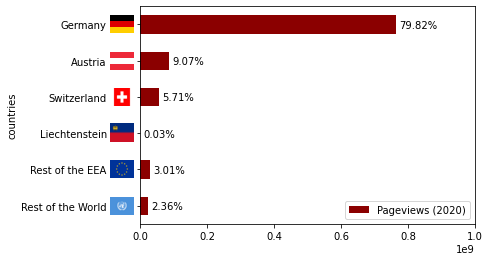

In [6]:
# Plotting data
        
ax = pv_origins.plot.barh('countries', 'Pageviews (2020)', color='darkred')
ax.invert_yaxis()
ax.set_xlim(right=1e9)
add_flags(ax)
add_prc(ax, pv_origins[['Pageviews (2020)']].values.flatten())

We can easily see that **97.64% of total pageviews** on ```de.wikipedia.org``` indeed come from countries strongly affected by GDPR. However, as the month studied is in 2020, it would be possible that COVID-19 changes things as compared to before. As a comparison basis to check it is not the case, we will compare those numbers with the ones of November 2019.

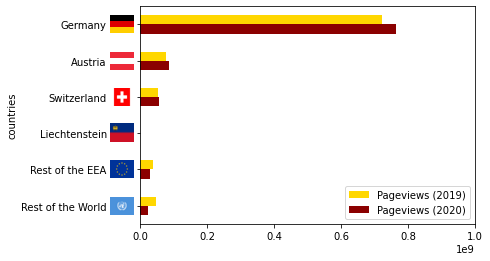

In [7]:
nov19 = pd.read_csv("data/11_2019.csv")
pv_origins['Pageviews (2019)'] = [nov19[nov19['country'].isin(country)][['total.total']].values.sum() for country in countries]

ax = pv_origins.plot.barh('countries', ['Pageviews (2019)','Pageviews (2020)'], color=['gold','darkred'])
ax.invert_yaxis()
ax.set_xlim(right=1e9)
add_flags(ax)

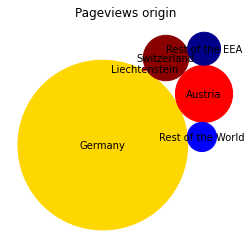

In [8]:
bubble_chart = BubbleChart(area=pv_origins[['Pageviews (2020)']],
                           bubble_spacing=0.1)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, pv_origins[['countries']], ['gold', 'red', 'darkred', 'red', 'darkblue', 'blue'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Pageviews origin')

plt.show()

Even though there are a few more views from the rest of the world in 2019 as compared to 2020, it still represents a neglibible portion of those. Moreover, one can guess this rise in pageviews fron the rest of the world come from german-speaking people who travel abroad, and who could not in 2020 because of COVID. Since these people originally would come from GDPR-affected countries, it is reasonable to think they were affected by it. **From those data, we can make the reasonable assumption that nearly all pageviews to ```de.wikipedia.org``` come from GDPR-affected users.**

## Choosing articles

Now that we know that using the German version of Wikipedia is relevant for our study, we have to select a subset of articles that is relevant to show whether GDPR entering into forced has caused a raise in interest for privacy protection in EU citizens.

We first wanted to isolate a first subset of articles that might be pertinent for our study: for that, we simply selected articles that were linked inside the GDPR Wikipedia article. Unfortunately, for the German version of the article, most linked articles were not abour privacy, but rather about European lawmaking. Since it clearly did not fit our goal, we privileged selecting links in the English article for which a German translation existed. The subset of 111 articles it yielded was indeed much more pertinent.

But some of them still were not relevant at all for our study. In order to filter them out, we used a crowdsourcing approach: we asked 13 test subjects to grade every article between 1 (not relevant) and 5 (very relevant) based on the following question: "*Which of these Wikipedia articles would you most likely consult to inform yourself on the protection of your personal data online?*"

## Loading data

To find the data, we used the Wikipedia REST API (https://wikimedia.org/api/rest_v1/#/Pageviews%20data), which provides access to Wikimedia content and data, including pageviews.

Some of the pages linked could not be loaded, most of them because there was no data during the epoch (page created afterward), and one because a problem with finding it in the API.

In [9]:
MONTHS = 28

def read_json_file(file_name, show_steps=False):

    df = pd.read_json(file_name, convert_dates=False)

    # Manually convert dates
    df.loc[:,'timestamp'] = df.loc[:,'timestamp'].apply(lambda x: datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:8])))
    if show_steps:
        print('Convert dates:')
        display(df.sample(5))

    # Drop useless columns
    df = df.drop(['project', 'granularity', 'access', 'agent'], axis=1)
    if show_steps:
        print('Drop useless columns:')
        display(df.sample(5))
        
    return df
   
df = read_json_file('data/pageviews.json')
    
# Drop articles that have data during only a subset of the period
for a in set(df.article):
    if len(df.loc[(df.article == a)]) < 28:
        df = df.loc[(df.article != a)]

df.sample(5)

,article,timestamp,views,rating
219,Gläserner_Mensch_(Datenschutz),2017-06-01,1572,3.69e+00
2611,Europäischer_Wirtschaftsraum,2017-01-01,24347,1.33e+00
240,Datenpanne,2016-11-01,406,3.58e+00
81,Datenschutzerklärung,2017-08-01,1539,4.00e+00
1552,Electronic_Frontier_Foundation,2015-07-01,714,2.15e+00


In [10]:
def to_monthly_pv(df):
    df = df.pivot(index='article', columns='timestamp', values='views')
    print("Data contains {} articles and {} monthly pageview counts".format(df.shape[0], df.shape[1])) 
    return df

monthly_pv = to_monthly_pv(df)
monthly_pv.sample(5)

Data contains 95 articles and 28 monthly pageview counts


timestamp,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,...,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01
article,,,,,,,,,,,,,,,,,,,,,
Los_Angeles_Times,897,813,890,944,1593,882,1075,930,1023,836,...,1335,1276,1159,761,1068,807,790,887,831,1013
Siri_(Software),12080,8686,11156,11015,9789,11446,12849,10104,8972,8586,...,11120,8520,9922,10780,10101,10210,11308,10931,9441,9068
Island,87622,82345,122101,107670,101428,93123,146572,96143,104539,124706,...,117273,111584,108787,71784,79810,87160,90710,96874,85470,135939
Europäische_Kommission,19962,10035,18873,20846,23614,17991,23150,22491,21953,21372,...,31477,22736,29083,18602,26205,19443,14869,11597,18528,21911
Gläserner_Mensch_(Datenschutz),885,926,1275,1331,1738,1354,1603,1654,1529,1718,...,1870,1564,1974,1315,1729,1572,888,874,1350,1417


## Removing outliers

After having had a few issues relative to data collection, we still have more than enough articles left with a total of 95. Before separating them with regard to their ratings (see later), we will remove outliers form our data.

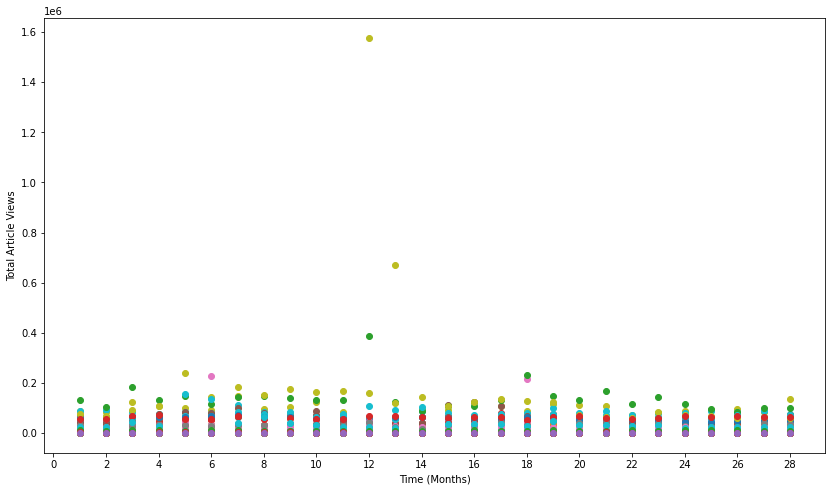

In [11]:
def scatter_base_figure():
    fig = plt.figure(figsize=(14,8))

    plt.xticks(np.arange(0, MONTHS+1, 2))
    plt.xlabel('Time (Months)')
    plt.ylabel('Total Article Views')
    
    return fig.axes[0]
    
scatter_base_figure()
    
for article in set(df.article):
    y = df.loc[(df.article == article), 'views']
    plt.scatter(range(1, MONTHS+1), y, label=article)

We can clearly see there are some outliers: we have to identify and remove them.

In [12]:
df[df['views'] > 0.3e6]

,article,timestamp,views,rating
1891,Europäische_Union,2016-06-01,388199,1.83e+00
2548,Island,2016-06-01,1577344,1.38e+00
2549,Island,2016-07-01,669120,1.38e+00


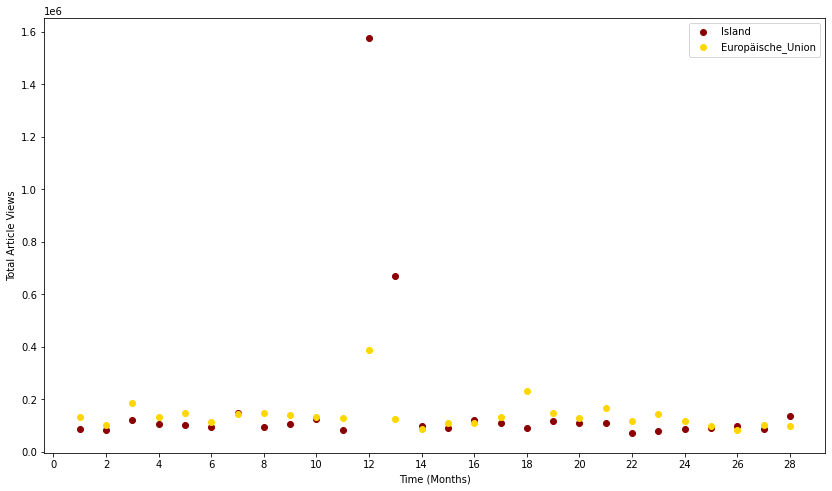

In [13]:
scatter_base_figure()

plt.scatter(range(1, MONTHS+1), df.loc[(df.article == 'Island'), 'views'], label='Island', color='darkred')
plt.scatter(range(1, MONTHS+1), df.loc[(df.article == 'Europäische_Union'), 'views'], label='Europäische_Union', color='gold')
plt.legend()

Data contains 93 articles and 28 monthly pageview counts


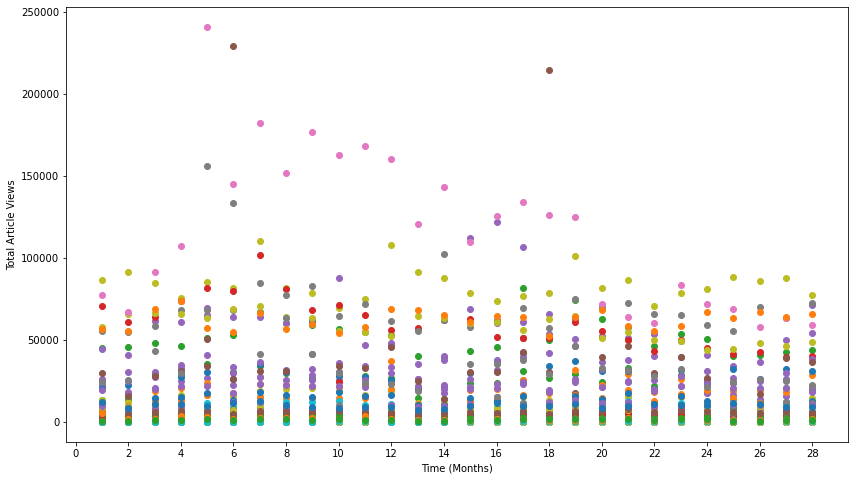

In [14]:
df = df.loc[(df.article != 'Island') & (df.article != 'Europäische_Union')]
monthly_pv = to_monthly_pv(df)

scatter_base_figure()
    
for article in set(df.article):
    y = df.loc[(df.article == article), 'views']
    plt.scatter(range(1, MONTHS+1), y, label=article)

We see that two articles, namely about the European Union and Iceland, are strong outliers inside our dataset. There are very logical explanations for this:
- Iceland stands out in June and July 2016 because of their results during the Football World Cup of 2016
- The EU stands out in June 2016 because of the Brexit vote happening the same month

In order to preserve the validity of our regressions later on, we remove both articles from the dataset.

## Separating articles by privacy rating

Now that outliers have been removed, we still have 93 articles of varying pertinence. We want to isolate those that are interesting with regard to information about personal privacy protection from others. In order to achieve that with a minimum of scientific validity, we used crowdsourcing.

We asked a group of 13 subjects to rate every article from 1 (completely irrelevant) to 5 (very relevant) with regard to the following question: "*Which of these Wikipedia articles would you most likely consult to inform yourself on the protection of your personal data online?*". Mean article rating already appears in our DataFrame.

In [15]:
df.sample(5)

,article,timestamp,views,rating
167,Datenschutz_im_Internet,2017-10-01,783,3.85e+00
1939,Europäische_Kommission,2015-10-01,20846,1.77e+00
474,Bundesbeauftragter_für_den_Datenschutz_und_die...,2016-06-01,1296,3.23e+00
387,Europäischer_Datenschutzbeauftragter,2016-03-01,195,3.38e+00
2271,BBC_Radio_4,2016-05-01,391,1.54e+00


For our study, we will thus separate articles in two categories (articles belonging to none of the two being droped altogether):
- Articles relevant for information on personnal privacy protection ("*privacy-related articles*" thereafter): rating >= 3.0
- Articles related to GDPR but irrelevant for information on personnal privacy protection ("*comparison articles*" thereafter): rating <= 2.0

We chose those numbers so that privacy-related articles are only the ones having a mean rating in the upper half of our scale. Then, we picked the threshold for the comparison set in order for the total number of articles to be roughly comparable.

In [16]:
privacy = df[df['rating'] >= 3.0]
privacy_monthly_pv = to_monthly_pv(privacy)
print("Mean privacy rating for privacy-related articles: {:.2f}".format(privacy['rating'].mean()))

Data contains 22 articles and 28 monthly pageview counts
Mean privacy rating for privacy-related articles: 3.55


In [17]:
comparison = df[df['rating'] <= 2.0]
comparison_monthly_pv = to_monthly_pv(comparison)
print("Mean privacy rating for comparison articles: {:.2f}".format(comparison['rating'].mean()))

Data contains 38 articles and 28 monthly pageview counts
Mean privacy rating for comparison articles: 1.60


Let us visualise the look of our privacy-related articles set!

In [43]:
privacy_monthly_pv.sum(axis=1)

article
Arbeitnehmerdatenschutz                                                  44257
Bundesbeauftragter_für_den_Datenschutz_und_die_Informationsfreiheit      37368
Children’s_Online_Privacy_Protection_Act                                  3538
Commission_Nationale_de_l’Informatique_et_des_Libertés                    2728
Data_Protection_Commissioner                                              1998
Datenpanne                                                               10099
Datenschutz                                                             390519
Datenschutz-Grundverordnung                                             284382
Datenschutz_im_Internet                                                  28868
Datenschutzerklärung                                                     42442
Datenschutzrecht                                                         38902
Datenvernichtung                                                         11155
Eidgenössischer_Datenschutz-_und_Öffentlichk

In [45]:
ratings = privacy.drop(['timestamp', 'views'], axis=1).drop_duplicates().sort_values('article')
ratings.head()

,article,rating
336,Arbeitnehmerdatenschutz,3.54e+00
463,Bundesbeauftragter_für_den_Datenschutz_und_die...,3.23e+00
435,Children’s_Online_Privacy_Protection_Act,3.31e+00
546,Commission_Nationale_de_l’Informatique_et_des_...,3.15e+00
574,Data_Protection_Commissioner,3.08e+00


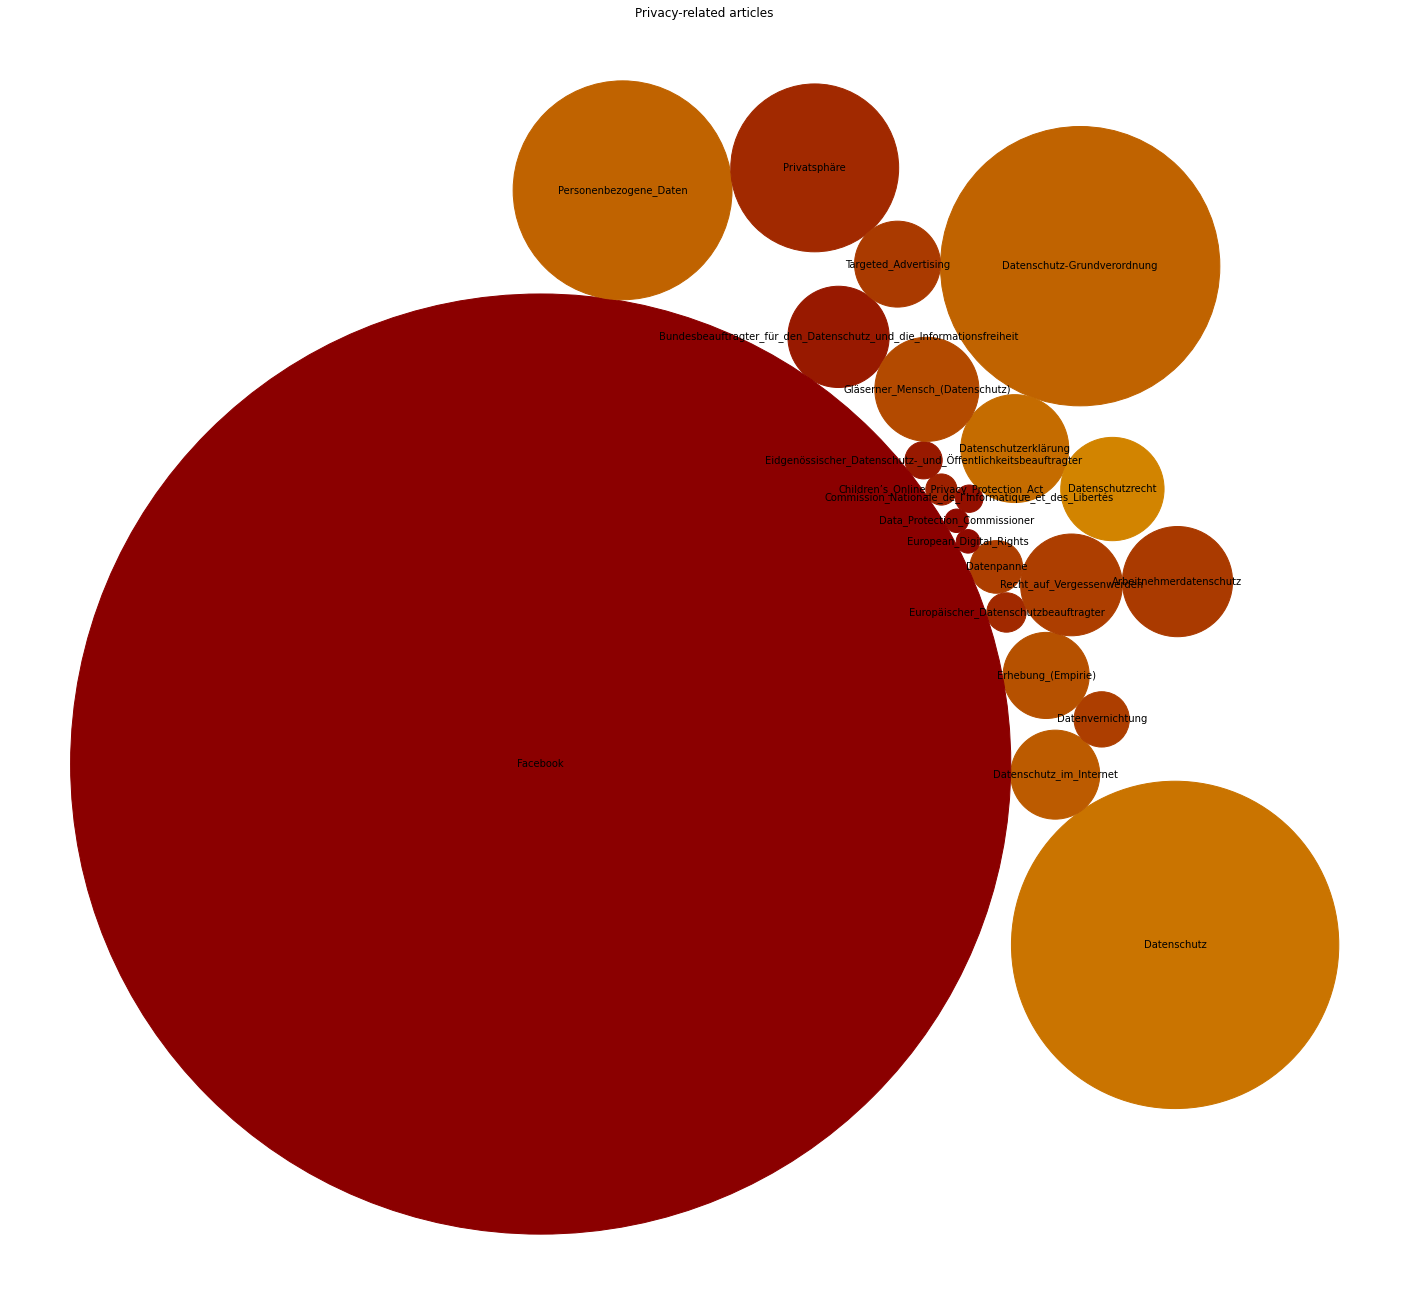

In [52]:


bubble_chart = BubbleChart(area=privacy_monthly_pv.sum(axis=1).values,
                           bubble_spacing=0.1)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
fig.set_size_inches(25, 25)
bubble_chart.plot(
    ax, privacy_monthly_pv.sum(axis=1).index, [colorFader('darkred', 'gold', (r-3.0)/2.0) for r in ratings[['rating']].values])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Privacy-related articles')

plt.show()

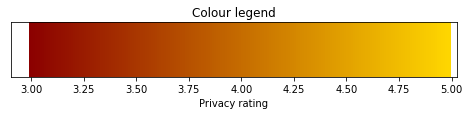

In [64]:
n = 500
fig, ax = plt.subplots(figsize=(8, 1))
for x in np.arange(3, 5, 0.01):
    ax.axvline(x, color=colorFader('darkred','gold',(x-3.0)/2.0), linewidth=4) 
    
ax.set_title('Colour legend')
plt.xlabel('Privacy rating')
ax.get_yaxis().set_visible(False)
plt.show()

Int

## First glance at privacy-related articles trend

Now that our data is ready for use, we will be taking a first look at how the trend looks like for privacy-related articles.

Our data takes the form of an Interrupted Time Series (ITS): a series of measurments on the time axis, interrupted by a sudden event at some point in time. Here, this sudden event is the adoption of GDPR on April 14 2016.

As for the rest of this study, we will be using a standard method for this kind of analysis: Segmented Regression of an Interrupted Time Series, as described in (1) and (2). We first need to augment our pageviews Series with four different counters:
 * *ones* will determine the constant parameter β_0
 * *time* counts the time from the beginning of the time series, in months, and will help us determine β_1, the secular trend in data
 * *intervention* is basically a boolean, describing whether we are past the interruption or not, and will help us determine β_2, the change in level
 * *postslope* is the time in months from the interruption, and will help us determine β_3, the change in slope
 
In order to determine those coefficients, we will us linear regression with gradient descent on all those dimensions.

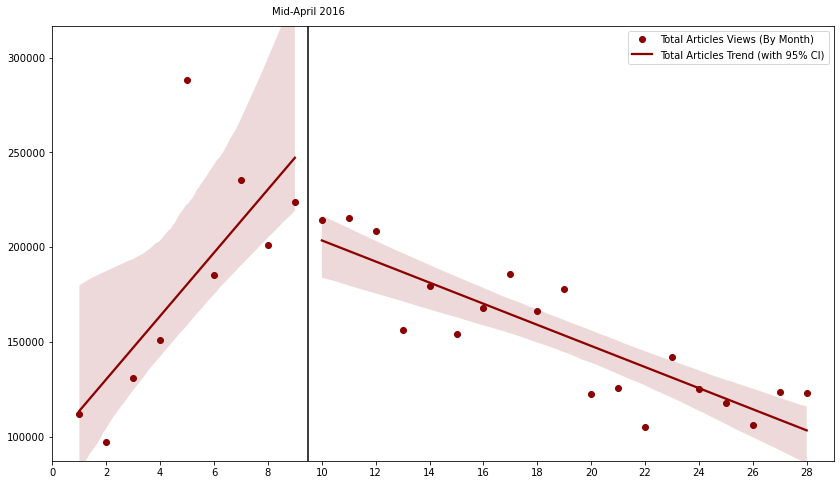

In [18]:
INTERRUPTION_DAY = 9.5
INTERRUPTION_MONTH = 10

def scatter_ITS_figure(primary, secondary=None, label='Total Articles', label_sec='Total Articles'):
    """Draws a scatter plot with trends for Interrupted Time Series analysis
    
    :argument primary: monthly pageviews DataFrames for primary time series
    :argument secondary: eventual monthly pageviews DataFrames for secondary (comparison) time series
    :argument label: eventual title for the primary series
    :argument label_sec: eventual title for the secondary series"""
    
    ax = scatter_base_figure()
    
    primary = primary.sum()
    primary.index = np.arange(1, primary.index.shape[0]+1)
    
    ax.plot(primary, marker='o', ls='', color='darkred', label=label + ' Views (By Month)')
    
    # Adding trends
    sns.regplot(x=primary[:9].index, y=primary[:9], scatter=False, truncate=True, color='darkred', label=label + ' Trend (with 95% CI)', ax=ax)
    sns.regplot(x=primary[9:].index, y=primary[9:], scatter=False, truncate=True, color='darkred', ax=ax)
    
    if secondary is None:
        ax.set_ylim(primary.min()*0.9, primary.max()*1.1)
        ax.text(INTERRUPTION_DAY, primary.max()*1.12, "Mid-April 2016", color='black', ha='center')
    else:
        secondary = secondary.sum()
        secondary.index = np.arange(1, secondary.index.shape[0]+1)
        
        ax.plot(secondary, marker='o', ls='', color='gold', label=label_sec + ' Views (By Month)')
        
        sns.regplot(x=secondary[:9].index, y=secondary[:9], scatter=False, truncate=True, color='gold', label=label_sec + ' Trend (with 95% CI)', ax=ax)
        sns.regplot(x=secondary[9:].index, y=secondary[9:], scatter=False, truncate=True, color='gold', ax=ax)
        
        data = pd.concat([primary, secondary])
        ax.set_ylim(data.min()*0.9, data.max()*1.1)
        ax.text(INTERRUPTION_DAY, data.max()*1.12, "Mid-April 2016", color='black', ha='center')
    
    # Adding a vertical line to mark mid-April 2016
    ax.axvline(INTERRUPTION_DAY, color='black')
    ax.set_xlim(0, MONTHS+1)
    
    # Adding legend
    ax.legend()
    
scatter_ITS_figure(privacy_monthly_pv)

The results are pretty unambiguous and there is a clear trend change at the interruption time. In order to confirm this visualisation, we will compute the beta coefficients.

In [19]:
intervention = np.concatenate((np.zeros(INTERRUPTION_MONTH, dtype=np.int64), np.ones(privacy_monthly_pv.shape[1]-INTERRUPTION_MONTH, dtype=np.int64)))
postslope = np.concatenate((np.zeros(INTERRUPTION_MONTH, dtype=np.int64), np.arange(1, privacy_monthly_pv.shape[1]-INTERRUPTION_MONTH+1)))

def compute_betas(df):
    df = df.sum()
    model = pd.DataFrame({'pageviews':df,'ones': np.ones(df.shape[0], dtype=np.int64), 'time':np.arange(1,df.shape[0]+1), 'intervention':intervention, 'postslope':postslope})
    betas = LinearRegression(fit_intercept=False).fit(model[['ones', 'time', 'intervention', 'postslope']].values, model['pageviews'].values).coef_
    return pd.Series(index=['β_0','β_1','β_2','β_3'], data=betas)
    
privacy_betas = compute_betas(privacy_monthly_pv)
privacy_betas

β_0    1.07e+05
β_1    1.40e+04
β_2   -4.59e+04
β_3   -1.94e+04
dtype: float64

Here again, results are unambiguous: there is a lasting change of trend after the interruption, with the total number of pageviews shrinking. Let us take a look at the possible causes:
- People felt reassured enough by GDPR adoption to not have to protect their privacy by themselves
- People were more interested in privacy-related topics before GDPR adoption, since the topic was probably more discussed in media than after, like most of laws

## Comparison with the other articles group

In order to either confirm or contradict these conjectures, we have to compare these results with our comparison articles, in order to see if articles less informative on privacy protection followed the same trend or not.

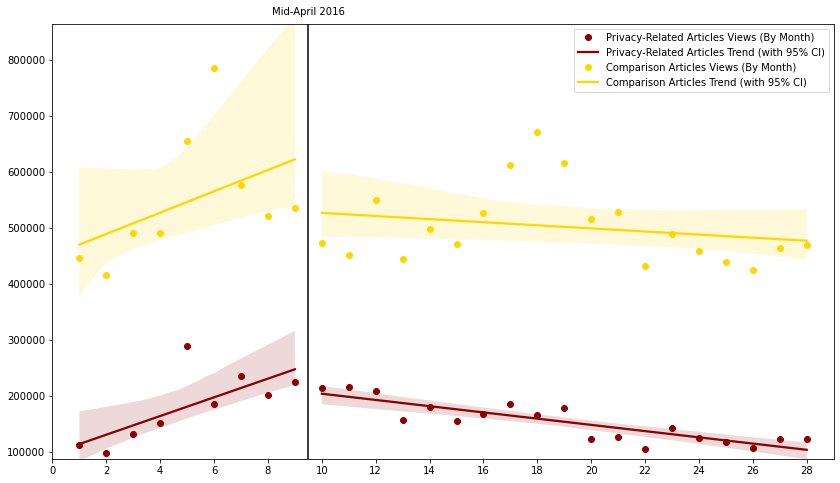

In [20]:
scatter_ITS_figure(privacy_monthly_pv, comparison_monthly_pv, 'Privacy-Related Articles', 'Comparison Articles')

We can easily see that articles less informative on privacy protection followed roughly the same trends as our first subset of articles. In order to confirm this, we compute the beta coefficients for this other series.

In [21]:
comparison_betas = compute_betas(comparison_monthly_pv)
pd.DataFrame({'privacy':privacy_betas, 'comparison':comparison_betas}, index=privacy_betas.index)

,privacy,comparison
β_0,1.07e+05,4.85e+05
β_1,1.40e+04,9.82e+03
β_2,-4.59e+04,-4.31e+04
β_3,-1.94e+04,-1.37e+04


This confirms the visual intuition: we easily see that secular trend and change in slope are very close to one another for both series.

From this, we can guess that our first conjecture, i.e. that people felt reassured enough by GDPR adoption to not have to protect their privacy by themselves, is likely to be false. Indeed, if it were a significant phenomenon, the change in trend would be significantly more important for privacy-related articles, which is not the case.

However, it seems to confirm a variation of the second conjecture where people simply lose interest in topics related to GDPR in general as this topic likely disappears from the media after its adoption.

## Comparing with popular Wikipedia articles

In order to confirm whether this trend is specific to GDPR or a global trend on Wikipedia, we will compare our data trend with the one of the most popular Wikipedia articles of 2015, 2016 and 2017 (the years studied for the GDPR-related articles).

Since we are summing all articles pageviews, it does not matter if articles differ from year to year.

In [22]:
df_2015 = to_monthly_pv(read_json_file('data/topviews-2015.json'))
df_2016 = to_monthly_pv(read_json_file('data/topviews-2016.json'))
df_2017 = to_monthly_pv(read_json_file('data/topviews-2017.json'))

popular = pd.DataFrame(index=range(50))

for df in [df_2015, df_2016, df_2017]:
    df.index = range(50)
    popular = popular.join(df)
    
popular = popular.drop(pd.to_datetime(['2017-11-01','2017-12-01']), axis=1)
popular.sample(5)

Data contains 50 articles and 6 monthly pageview counts
Data contains 50 articles and 12 monthly pageview counts
Data contains 50 articles and 12 monthly pageview counts


,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,...,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01
4,3.59e+04,1.22e+05,4.64e+05,1.75e+05,2.02e+05,8.41e+04,218134,198610,211302,198028,...,2.31e+05,1.28e+05,1.61e+05,1.39e+05,1.20e+05,1.09e+05,1.65e+05,9.91e+04,1.11e+05,1.01e+05
15,3.60e+05,2.56e+05,2.45e+05,2.16e+05,2.22e+05,2.41e+05,144411,129115,129700,123897,...,1.76e+05,1.26e+05,1.52e+05,1.35e+05,1.47e+05,1.25e+05,1.07e+05,1.39e+05,1.31e+05,1.63e+05
18,8.78e+04,8.47e+04,1.61e+05,1.54e+05,1.76e+05,1.11e+05,163923,118726,182636,165906,...,3.88e+05,3.01e+05,2.95e+05,2.33e+05,1.89e+05,2.24e+05,5.56e+05,8.66e+05,4.41e+05,2.48e+05
34,4.59e+04,6.07e+04,1.03e+05,2.56e+05,1.58e+05,1.40e+06,173878,162971,145120,141339,...,1.24e+05,1.47e+05,1.08e+05,1.61e+05,1.51e+05,1.51e+05,1.57e+05,1.52e+05,1.40e+05,1.06e+05
13,1.28e+05,1.14e+05,1.38e+05,1.27e+05,2.25e+05,1.27e+05,182332,152012,177206,162728,...,3.72e+04,7.43e+04,8.27e+04,4.43e+05,5.26e+05,1.08e+05,1.12e+05,3.65e+04,3.52e+04,3.80e+04


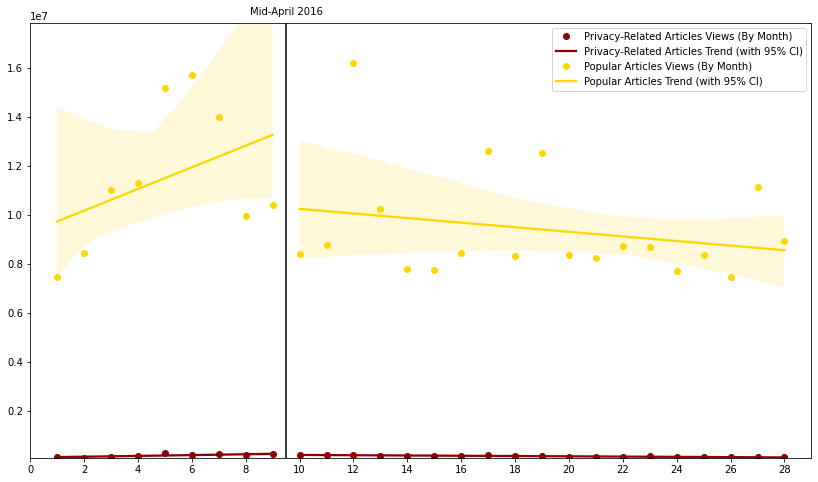

In [23]:
scatter_ITS_figure(privacy_monthly_pv, popular, 'Privacy-Related Articles', 'Popular Articles')

Since popular articles are much more numerous (50 vs 22), and also gather much more views each (as they are the most popular ones), it is clearly not possible to get a good visualisation of them together with our privacy-related articles. In order to get some intuition on trend, we will thus divide their total number of views by a constant in order to be able to visually compare the trend with the one of privacy-related articles.

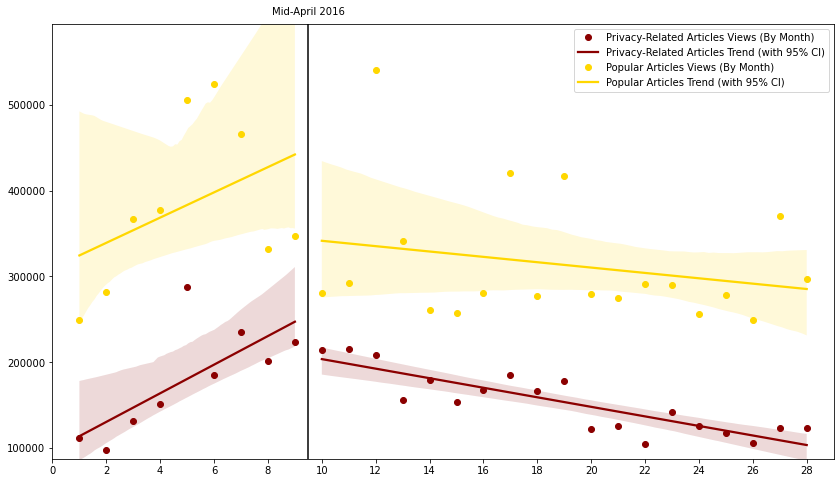

In [24]:
scatter_ITS_figure(privacy_monthly_pv, popular/30, 'Privacy-Related Articles', 'Popular Articles')

Here again, trends seem to be very similar. We compute the beta coefficients in order to verify this.

In [25]:
popular_betas = compute_betas(popular)
pd.DataFrame({'privacy':privacy_betas, 'popular':popular_betas}, index=privacy_betas.index)

,privacy,popular
β_0,1.07e+05,1.04e+07
β_1,1.40e+04,1.52e+05
β_2,-4.59e+04,-1.19e+06
β_3,-1.94e+04,-2.82e+05


Once again, the beta coefficients for secular trend and change in slope are very close to one another for both series. This shows that our set of privacy-related articles mostly follows general Wikipedia trend.

## Conclusion

Our work only shows that the number of pageviews for our set of privacy-related articles did only follow the general trend on Wikipedia. As such, we conclude that there is little to no correlation between the adoption of GDPR and the number of pageviews on privacy-related articles.

To explain this, we can make the following conjectures:
- GDPR adoption received too little publicity to meaningfully change the number of pageviews - this could be verified by looking at Google Trends for GDPR-related keywords, or Google News articles featuring the keyword `GDPR`.
- People do not use Wikipedia to gain knowledge on how to protect their privacy online but prefer other websites - this could be verified by looking at Google Trends for privacy-related keywords.
- GDPR adoption did not affect the propensity of users to want to protect their online privacy - if our previous conjecture is proven wrong, it means that this one is most probably true. This could be validated by behavioural studies.

Also, our study has different structural weaknesses:
- It lacks datapoints before the Interruption to be balanced on both sides; this is due to Wikipedia pageviews measurment changing in mid-2015
- It is unclear whether the adoption of a regulation can be considered like an Interruption, since lawmaking is a process usually taking time

In conclusion, even if our study does only prove the absence of correlation between the number of pageviews on privacy-related articles and the adoption of GDPR, it represents a basis on which studies could be constructed in order to assert the effectiveness of regulation on population awareness of privacy concerns.

### References

(1) Mylene Lagarde, How to do (or not to do) … Assessing the impact of a policy change with routine longitudinal data, Health Policy and Planning, Volume 27, Issue 1, January 2012, Pages 76–83, https://doi.org/10.1093/heapol/czr004

(2) Wagner AK, Soumerai SB, Zhang F, Ross-Degnan D. Segmented regression analysis of interrupted time series studies in medication use research. J Clin Pharm Ther. 2002 Aug;27(4):299-309. doi: 10.1046/j.1365-2710.2002.00430.x. PMID: 12174032